##### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.lines as lines

##### Reading the image and converting it to grayscale

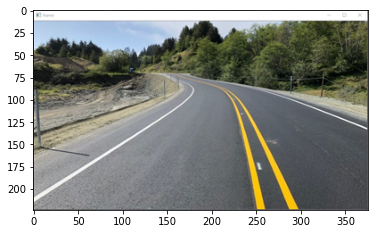

In [2]:
img=cv2.imread('lane3.jpeg')
#img=cv2.resize(img)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

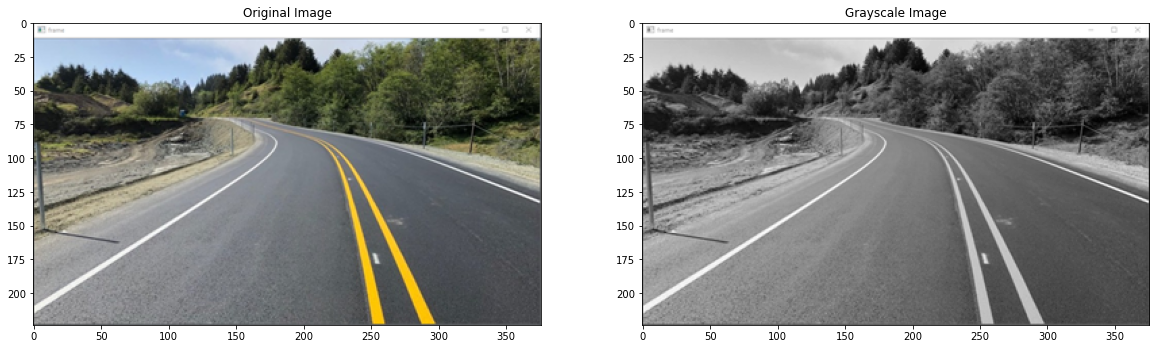

In [3]:
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

fig=plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title('Grayscale Image')
plt.imshow(img_gray,cmap='gray')
plt.show()

##### Trying different image processing techniques

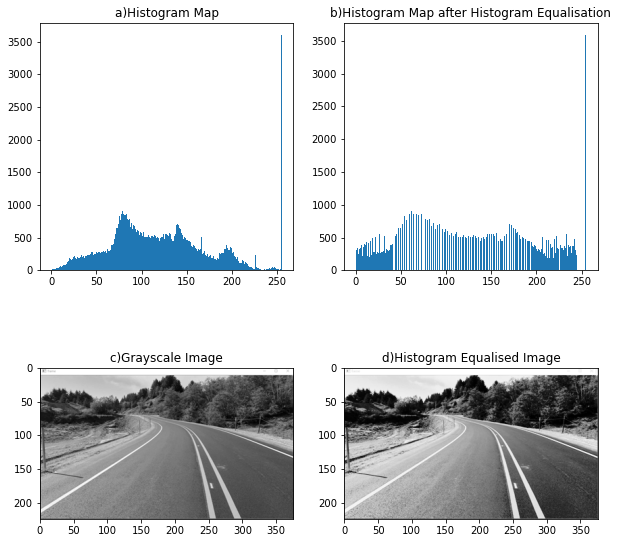

In [4]:
# Histogram Equalisation

figure=plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('a)Histogram Map')
plt.hist(img_gray.ravel(),bins=range(256))

img_hist=cv2.equalizeHist(img_gray)
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
#img_hist = clahe.apply(img_gray)
plt.subplot(2,2,2)
plt.title('b)Histogram Map after Histogram Equalisation')
plt.hist(img_hist.ravel(),bins=range(256))

plt.subplot(2,2,3)
plt.title('c)Grayscale Image')
plt.imshow(img_gray,cmap='gray')

plt.subplot(2,2,4)
plt.title('d)Histogram Equalised Image')
plt.imshow(img_hist,cmap='gray')


##### Blurring and Edge detection

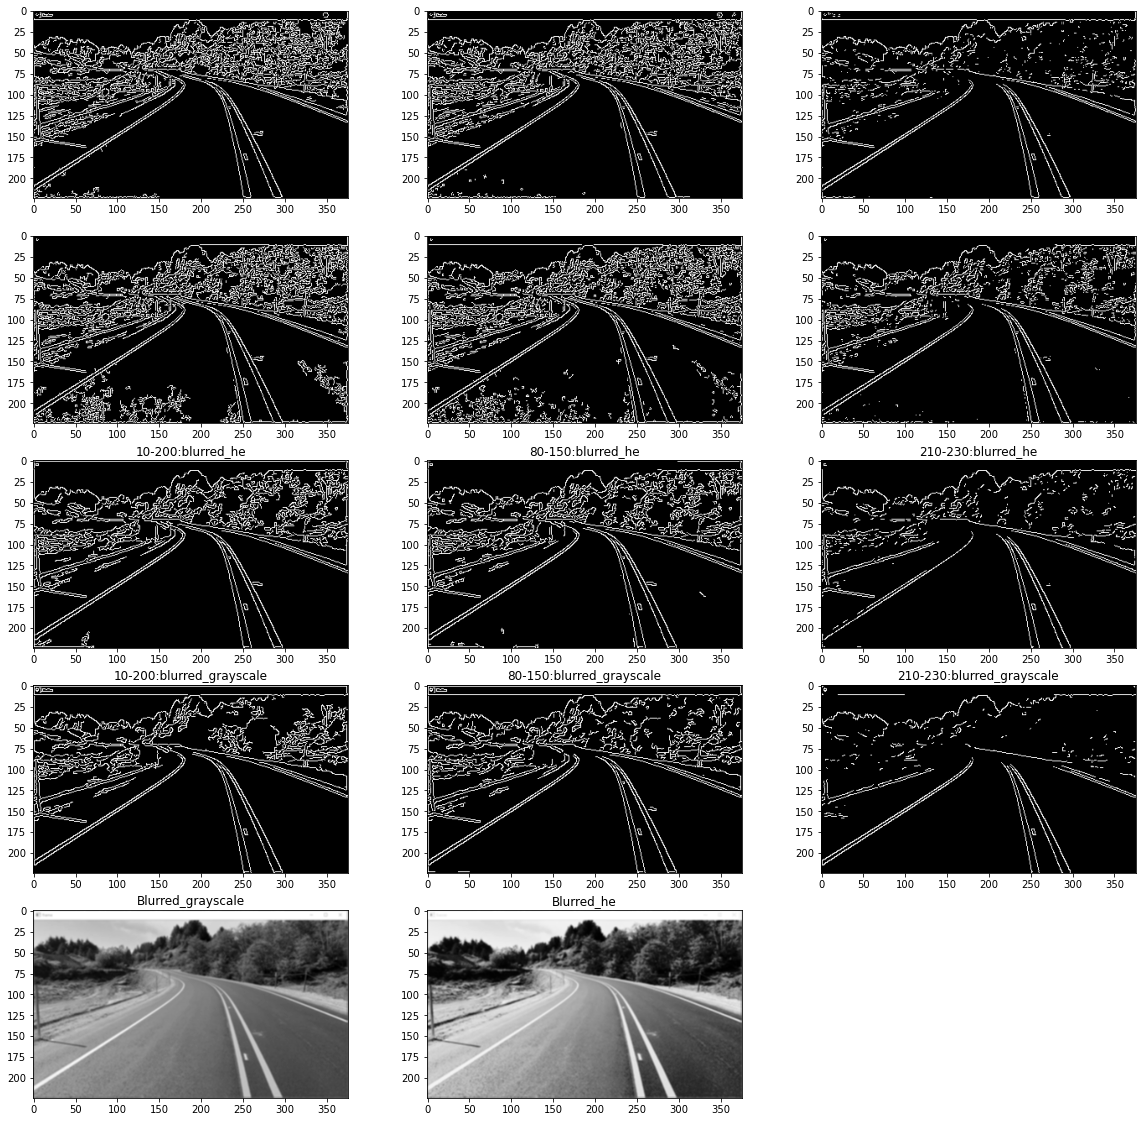

In [5]:
fig=plt.figure(figsize=(20,20))

r=5
c=3

# canny edge detection on grayscale image
wide = cv2.Canny(img_gray, 50, 200)
mid = cv2.Canny(img_gray, 80, 150)
tight = cv2.Canny(img_gray, 210,230)

# canny edge detection on histogram equalised image
wide_h = cv2.Canny(img_hist, 50, 200)
mid_h = cv2.Canny(img_hist, 80,150)
tight_h = cv2.Canny(img_hist, 210,230)

# canny edge detection on blurred and histogram equalised image
blurr=cv2.GaussianBlur(img_hist,(3,3),0)
wide_bh = cv2.Canny(blurr, 50, 200)
mid_bh = cv2.Canny(blurr, 80,150)
tight_bh = cv2.Canny(blurr, 210,230 )

# canny edge detection on blurred grayscale image
blurr_b=cv2.GaussianBlur(img_gray,(3,3),0)
wide_b = cv2.Canny(blurr_b, 50, 200)
mid_b = cv2.Canny(blurr_b, 80,150)
tight_b = cv2.Canny(blurr_b, 210,230 )

fig.add_subplot(r,c,1)
plt.imshow(wide,cmap='gray')

fig.add_subplot(r,c,2)
plt.imshow(mid,cmap='gray')

fig.add_subplot(r,c,3)
plt.imshow(tight,cmap='gray')

fig.add_subplot(r,c,4)
plt.imshow(wide_h,cmap='gray')

fig.add_subplot(r,c,5)
plt.imshow(mid_h,cmap='gray')

fig.add_subplot(r,c,6)
plt.imshow(tight_h,cmap='gray')

fig.add_subplot(r,c,7)
plt.title('10-200:blurred_he')
plt.imshow(wide_bh,cmap='gray')

fig.add_subplot(r,c,8)
plt.title('80-150:blurred_he')
plt.imshow(mid_bh,cmap='gray')

fig.add_subplot(r,c,9)
plt.title('210-230:blurred_he')
plt.imshow(tight_bh,cmap='gray')

fig.add_subplot(r,c,10)
plt.title('10-200:blurred_grayscale')
plt.imshow(wide_b,cmap='gray')

fig.add_subplot(r,c,11)
plt.title('80-150:blurred_grayscale')
plt.imshow(mid_b,cmap='gray')

fig.add_subplot(r,c,12)
plt.title('210-230:blurred_grayscale')
plt.imshow(tight_b,cmap='gray')

fig.add_subplot(r,c,13)
plt.title('Blurred_grayscale')
plt.imshow(blurr_b,cmap='gray')

fig.add_subplot(r,c,14)
plt.title('Blurred_he')
plt.imshow(blurr,cmap='gray')



plt.show()

##### Using masking to extract region of interest

(224, 376)


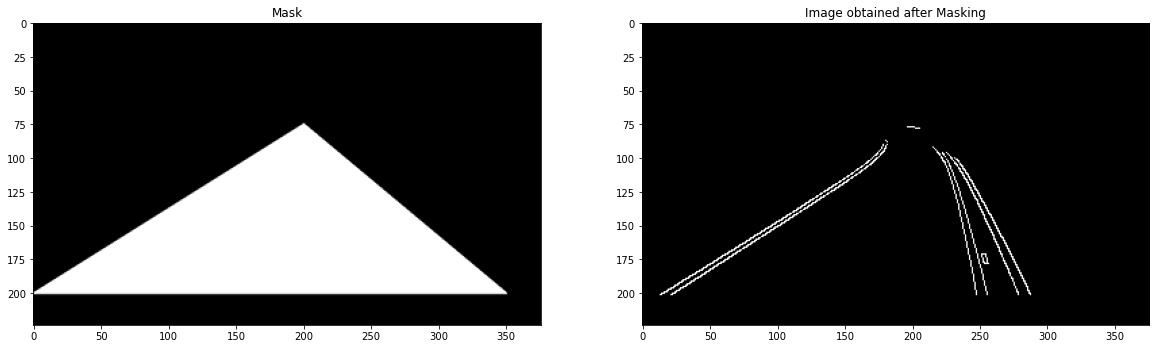

In [6]:
print(img.shape[:2])
mask=np.zeros(img.shape[:2],dtype='uint8')
points=np.array([[0,200],[200,75],[350,200]])#creating a triangular mask 
cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)

fig=plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Mask')
plt.imshow(mask,cmap='gray')

# masking to extract the region of interest
img_roi=tight.copy()
res = cv2.bitwise_and(tight_b,tight_b,mask = mask)
plt.subplot(1,2,2)
plt.title('Image obtained after Masking')
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

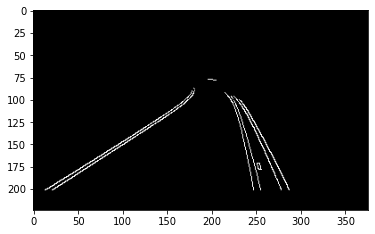

In [7]:
# erosion operation
res1=cv2.erode(res,(8,8))
plt.imshow(res,cmap='gray')

##### Defining Hough_line class for implementing Hough line detection Algorithm

In [8]:
class Hough_line:
    
    # constructor to initialise the necessary variables
    def __init__(self,thresh,orig_img,edge_img):
        self.threshold=thresh
        self.orig_img=orig_img.copy()
        self.edge_img=edge_img.copy()
        self.acc=[[]]
        self.line_plt=[]
        self.peak_plt=[]
        self.h_r_t=[]
      
    # function to set and compute the accumulator matrix
    def compute_acc(self):
        height=self.orig_img.shape[0]
        width=self.orig_img.shape[1]
        diag_len=np.sqrt(np.square(height)+np.square(width))
        r=np.arange(-diag_len,+diag_len,(2*diag_len)/180)
        t1=np.arange(0,180,step=1)
        t=np.deg2rad(t1)
        self.acc=np.zeros((len(r),len(t)))
        edges=np.argwhere(self.edge_img[:,:])
        for edge_point in edges:
            x_pt=edge_point[0]-height/2
            y_pt=edge_point[1]-width/2
            h_r=[]
            h_t=[]
            for theta in range(len(t1)):
                rho = (y_pt * np.cos(t[theta])) + (x_pt * np.sin(t[theta]))
                theta_ind =theta
                rho_ind = np.argmin(np.abs(r - rho))
                self.acc[rho_ind][theta_ind] += 1
                h_r.append(rho)
                h_t.append(t1[theta])
            self.h_r_t.append((h_r,h_t))
        self.detect_lines(r,t,t1)

    #function to detect the lines most likely to occur and finding their coordinates
    def detect_lines(self,r,t,t1):
        height=self.acc.shape[0]
        width=self.acc.shape[1]
        for x in range(height):
            for y in range(width):
                if self.acc[x][y] >self.threshold:
                    rho = r[x]
                    theta =t1[y]
                    b= np.cos(t[y])
                    a = np.sin(t[y])
                    x0 = (a * rho) + self.orig_img.shape[0]/2
                    y0 = (b * rho) + self.orig_img.shape[1]/2
                    x1 = int(x0 + 1000 * (-b))
                    y1 = int(y0 + 1000 * (a))
                    x2 = int(x0 - 1000 * (-b))
                    y2 = int(y0 - 1000 * (a))
                    self.peak_plt.append([rho,theta])
                    self.line_plt.append([x1,y1,x2,y2])
                        
    #function to plot all the required images
    def plot_img(self):
        figure = plt.figure(figsize=(10, 10))

        subplot1 = figure.add_subplot(2, 2, 1)
        subplot1.title.set_text('a)Original Image')
        subplot1.imshow(cv2.cvtColor(self.orig_img,cv2.COLOR_BGR2RGB))

        subplot2 = figure.add_subplot(2, 2, 2)
        subplot2.title.set_text('b)Edge Detected Image')
        subplot2.imshow(self.edge_img, cmap="gray")

        subplot3 = figure.add_subplot(2, 2, 3)
        subplot3.title.set_text('c)Hough Space')
        subplot3.set_facecolor((0,0,0))
        for h_r,h_t in self.h_r_t:
            subplot3.plot(h_t,h_r, color="white", alpha=0.05)
        for rho,theta in self.peak_plt:
            subplot3.plot(theta,rho, marker='o', color="red")

        subplot4 = figure.add_subplot(2, 2, 4)
        subplot4.title.set_text('d)Detected lines')
        for x1,y1,x2,y2 in self.line_plt:
            subplot4.add_line(lines.Line2D([y1, y2], [x1, x2],color='red'))
        subplot4.imshow(cv2.cvtColor(self.orig_img,cv2.COLOR_BGR2RGB))
        plt.show()


##### Detecting Lanes using Hough's Algorithm

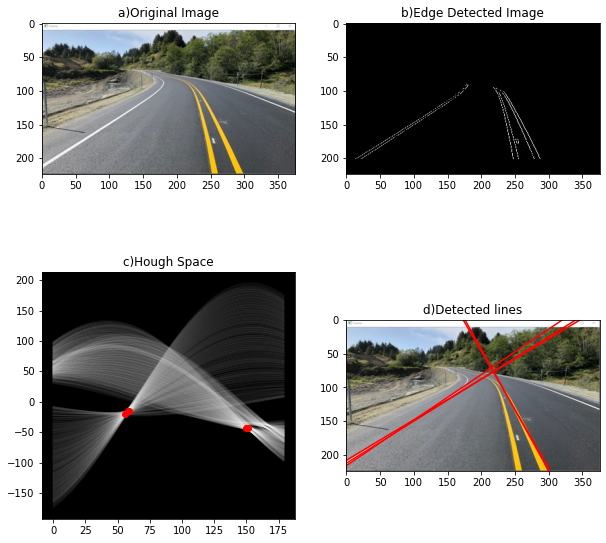

In [16]:

hl=Hough_line(115,img,res1)
hl.compute_acc()
hl.plot_img()
